In [ ]:
!pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import torch

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm.auto import tqdm
from transformers import BertModel, BertTokenizer

In [ ]:
!nvidia-smi

Tue Apr  2 21:51:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# class SarcasticHeadlinesDataset(Dataset):
#     def __init__(self, json_file_path, tokenizer, max_length=512):
#         self.data = []
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#         # Load and store data from JSON file
#         with open(json_file_path, 'r') as file:
#             for line in file:
#                 item = json.loads(line)
#                 self.data.append((item['headline'], item['is_sarcastic']))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         text, label = self.data[idx]
#         inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
#         input_ids = inputs['input_ids'].squeeze()
#         attention_mask = inputs['attention_mask'].squeeze()
#         return input_ids, attention_mask, torch.tensor(label)


In [ ]:
class SarcasticHeadlinesDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        headline = str(self.data.iloc[index]['headline'])
        inputs = self.tokenizer.encode_plus(
            headline,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.data.iloc[index]['is_sarcastic'], dtype=torch.float)
        }

    def __len__(self):
        return self.len

In [ ]:
class SarcasmDetector(nn.Module):
    def __init__(self):
        super(SarcasmDetector, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(in_channels=768, out_channels=100, kernel_size=2, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.1),

            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.1),

            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=4, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.1),

            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.1)
        )
        self.lstm = nn.LSTM(input_size=100, hidden_size=32, num_layers=1, batch_first=True, bidirectional=False)
        # lstm layer in pytorch inherently uses 'tanh' activation function for the cell state
          # and the sigmoid activation function for the gates internally -- no need to use them once more!!

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
        # where is the last sigmoid

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0].permute(0, 2, 1)

        cnn_output = self.cnn_layers(sequence_output)
        cnn_output = cnn_output.permute(0, 2, 1)
        lstm_output, (hidden, cell) = self.lstm(cnn_output)
        last_hidden = lstm_output[:, -1, :]
        logits = self.dense_layers(last_hidden)
        output = torch.sigmoid(logits).squeeze()

        return output

In [ ]:
# class BERT_CNN_LSTM(nn.Module):
#     def __init__(self, bert_model='bert-base-uncased', num_classes=2, freeze_bert=True):
#         super(BERT_CNN_LSTM, self).__init__()
#         self.bert_layer = BertModel.from_pretrained(bert_model)

#         if freeze_bert:
#             for param in self.bert_layer.parameters():
#                 param.requires_grad = False

#         self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=5, padding=2)  # Assuming using BERT base
#         self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(128, num_classes)

#     def forward(self, input_ids, attention_mask):
#         # BERT
#         outputs = self.bert_layer(input_ids, attention_mask=attention_mask)
#         last_hidden_state = outputs.last_hidden_state

#         # CNN
#         cnn_features = last_hidden_state.permute(0, 2, 1)  # [batch_size, hidden_size, seq_length]
#         cnn_features = torch.relu(self.conv1(cnn_features))

#         # LSTM
#         lstm_features, (hidden, cell) = self.lstm(cnn_features.permute(0, 2, 1))  # [batch_size, seq_length, num_filters]
#         lstm_features = hidden.squeeze(0)  # [batch_size, hidden_size]

#         # Fully Connected Layer
#         output = self.fc(lstm_features)

#         return output

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in train_loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(ids, mask).squeeze()

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        progress_bar.close()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

In [ ]:
# def train_model(model, train_loader, criterion, optimizer, num_epochs):
#     model.train()
#     for epoch in range(num_epochs):
#         total_loss = 0
#         progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

#         for batch in progress_bar:  # Here, we iterate through progress_bar instead of train_loader
#             ids = batch['ids'].to(device)
#             mask = batch['mask'].to(device)
#             targets = batch['targets'].to(device)

#             optimizer.zero_grad()
#             outputs = model(ids, mask).squeeze()

#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#             progress_bar.set_postfix(loss=loss.item())  # Display current loss
#             # No need to manually update the progress_bar since iterating over it does this automatically

#         avg_loss = total_loss / len(train_loader)
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')


In [ ]:
def evaluate_model1(model, val_loader):
    model.eval()
    val_targets = []
    val_outputs = []

    with torch.no_grad():
        for batch in val_loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)
            outputs = model(ids, mask).squeeze()

            val_targets.extend(targets.cpu().detach().numpy())
            val_outputs.extend(torch.round(outputs).cpu().detach().numpy())

    accuracy = accuracy_score(val_targets, val_outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_outputs, average='binary')

    print(f'Validation Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    true_labels = []
    predictions = []
    val_outputs = []

    with torch.no_grad():
        for batch in val_loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask).squeeze()
            probs = torch.sigmoid(outputs)

            true_labels.extend(targets.cpu().detach().numpy())
            val_outputs.extend(torch.round(outputs).cpu().detach().numpy())
            predictions.extend(probs.cpu().numpy())

    accuracy = accuracy_score(true_labels, val_outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, val_outputs, average='binary')

    print(f'Validation Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Calculate confusion matrix
    preds_binary = [1 if p > 0.5 else 0 for p in predictions]
    cm = confusion_matrix(true_labels, preds_binary)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print(f'Confusion Matrix:\n{cm}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Sarcasm_Headlines_Dataset_v2.json'
df = pd.read_json(file_path, lines=True)

In [ ]:
df.drop(columns="article_link", axis=1, inplace=True)
df.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df = df.drop_duplicates(subset = 'headline')
df.describe()

,is_sarcastic
count,28503.000000
mean,0.475459
std,0.499406
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df['headline'] = df['headline'].str.lower()
df['headline'] = df['headline'].apply(lambda x: re.sub('[^a-zA-Z\s]+|X{2,}', '', x))

# [@\^&\*\$] matches on the characters, you want to replace
#\S+matches on hash tags
# \S+[a-z0-9]\.(com|net|org) matches on domain names

df['headline'] = df['headline'].apply(lambda x: re.sub("[@\^&\*\$]|#\S+|\S+[a-z0-9]\.(com|net|org)"," ",x))

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the title, text
df['headline'] = df['headline'].apply(lambda x:expand_contractions(x))

In [ ]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# dataset = SarcasticHeadlinesDataset('/content/drive/MyDrive/Sarcasm_Headlines_Dataset_v2.json', tokenizer)
dataset = SarcasticHeadlinesDataset(dataframe=df, tokenizer=tokenizer, max_len=256)

In [ ]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # 80% of the dataset for training
val_size = dataset_size - train_size  # 20% for validation - always subtraction (or use scikit train-test split to do that automatically)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = SarcasmDetector()
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
num_epochs = 9

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SarcasmDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 1/9, Loss: 0.4180


Epoch 2/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 2/9, Loss: 0.3501


Epoch 3/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 3/9, Loss: 0.3236


Epoch 4/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 4/9, Loss: 0.2945


Epoch 5/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 5/9, Loss: 0.2761


Epoch 6/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 6/9, Loss: 0.2610


Epoch 7/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 7/9, Loss: 0.2456


Epoch 8/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 8/9, Loss: 0.2274


Epoch 9/9:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 9/9, Loss: 0.2178


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Accuracy: 0.8830
Precision: 0.8748, Recall: 0.8718, F1-Score: 0.8733


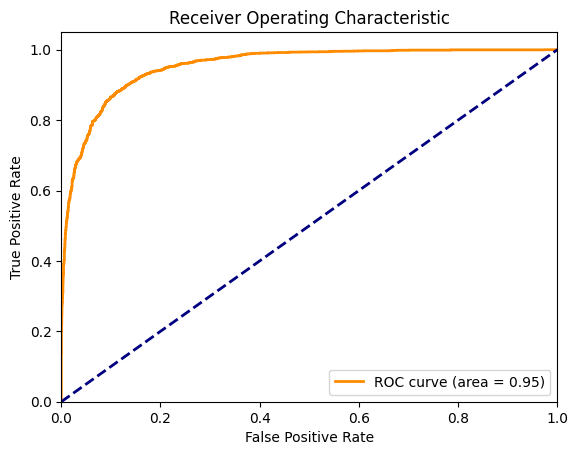

Confusion Matrix:
[[   0 3065]
 [   0 2636]]


In [ ]:
evaluate_model(model, val_loader)

In [ ]:
import pickle

model_pkl_file = "sarcasm_detection_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)
